 # Import Libraries

In [ ]:
pip install pyramid-arima

     |████████████████████████████████| 604kB 4.7MB/s 


In [ ]:
# pip install git+git://github.com/bashtage/arch.git

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import pylab
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from math import sqrt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from pyramid.arima import auto_arima
from datetime import datetime as dt
from datetime import timedelta
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
# from arch import arch_model
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

# Import Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/sj-leshrac/Stock_Market_Data/master/SENSEX2020.csv'
df = pd.read_csv(url)

In [ ]:
# Set Date as Index
df['Date'] = pd.to_datetime(df.Date)
df.set_index("Date", inplace = True) 

# Descriptives & Visualizations

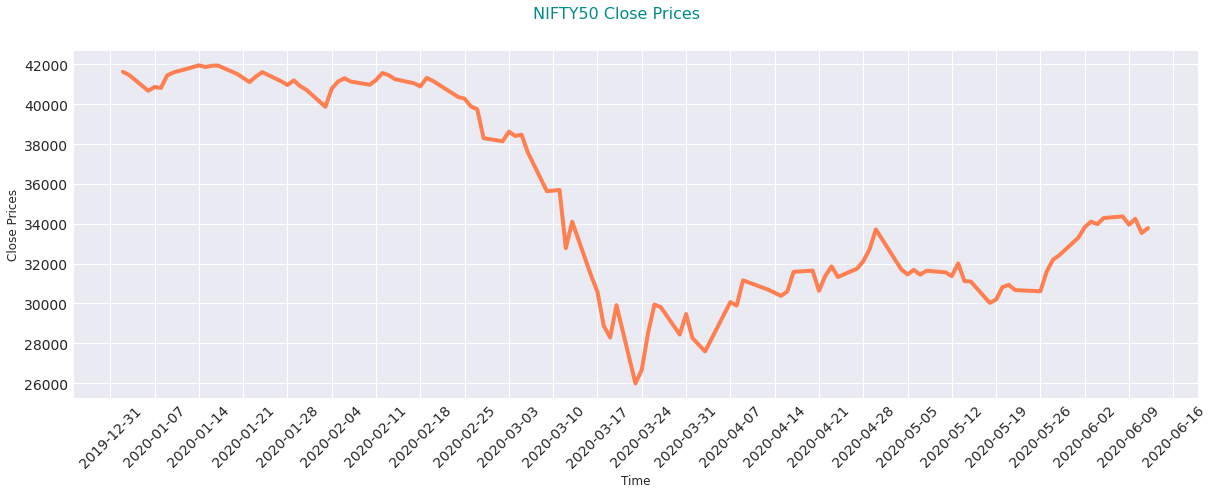

In [ ]:

# Line plot
rcParams['figure.figsize'] = 18,6
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("NIFTY50 Close Prices", fontsize=16, color='darkcyan')
plt.xticks(rotation=45)
ax = sns.lineplot(data=df["Close"], color="coral")
ax.tick_params(direction='out')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

#ax.get_legend().remove()
#ax.xaxis.set_major_locator(MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%b'))

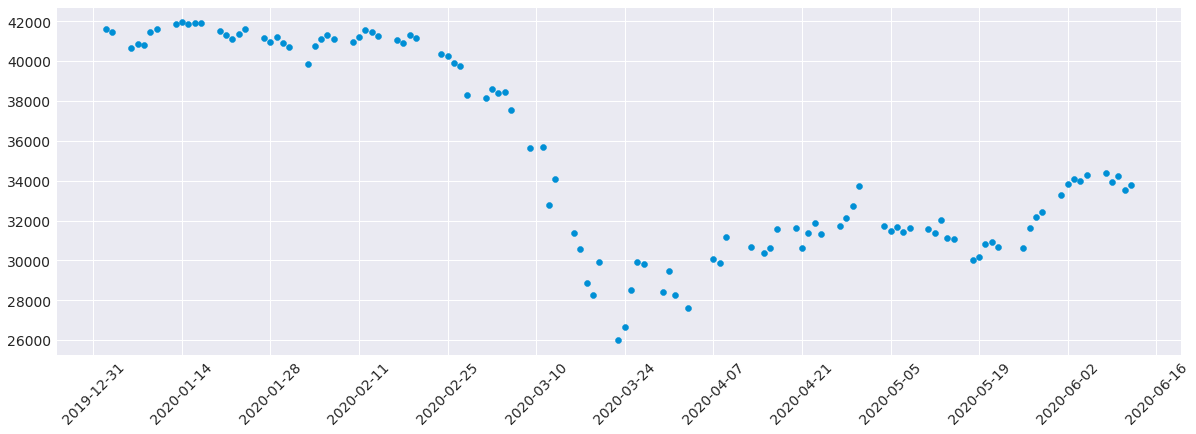

In [ ]:
# Scatter Plot
fig, ax = plt.subplots()
ax.scatter(x=df.index.values, y=df['Close'])
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.show()

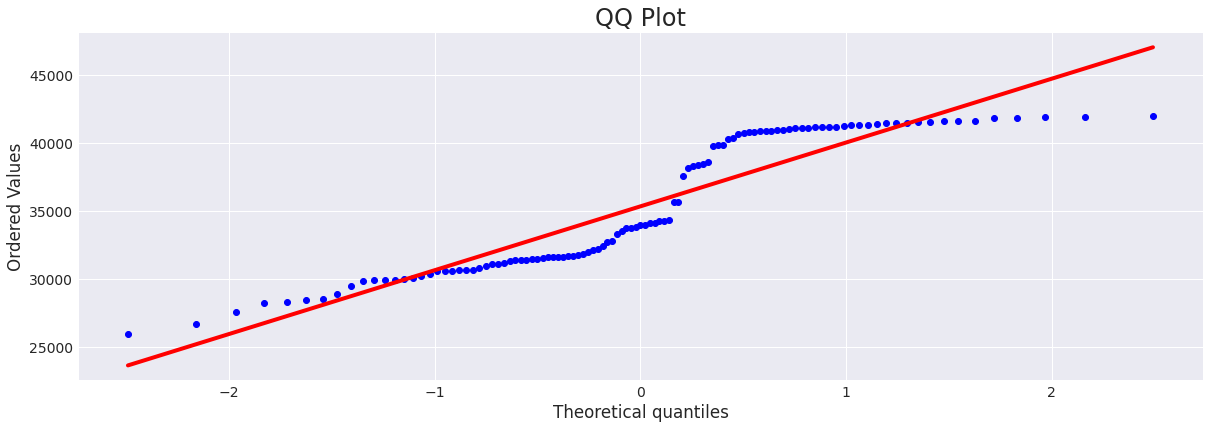

In [ ]:
scipy.stats.probplot(df.Close, plot = pylab)
plt.title("QQ Plot", size = 24)
pylab.show()

## Test For stationarity

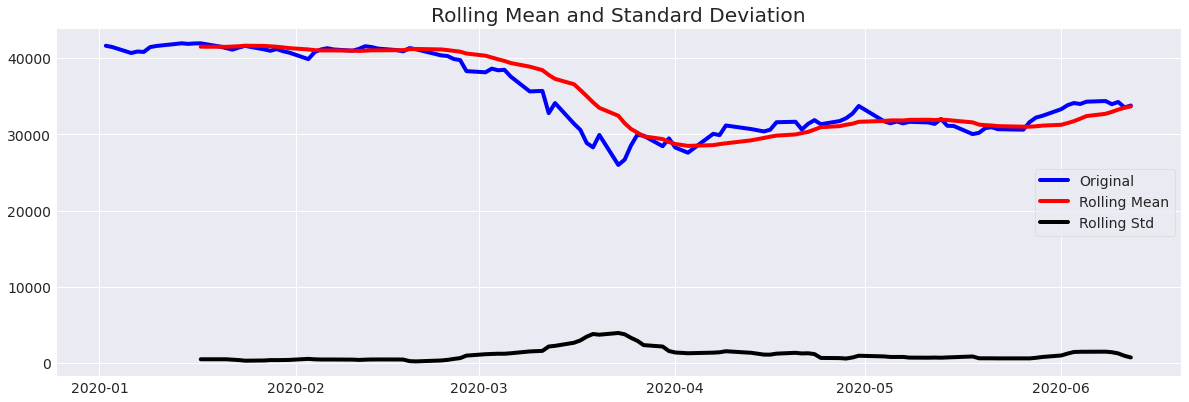

Results of dickey fuller test
Test Statistics                 -1.741643
p-value                          0.409795
No. of lags used                 7.000000
Number of observations used    101.000000
critical value (1%)             -3.496818
critical value (5%)             -2.890611
critical value (10%)            -2.582277
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

## Seperate trend and seasonality

<Figure size 1296x432 with 0 Axes>

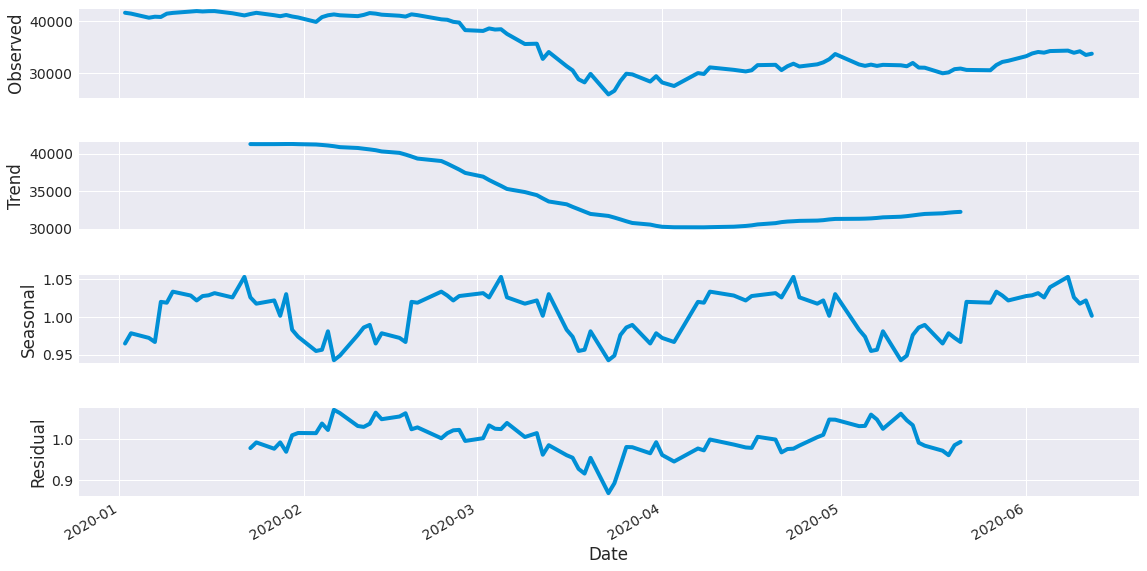

In [ ]:
# Multiplicative Seasonality
mult_seasonality = seasonal_decompose(df["Close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = mult_seasonality.plot() 
fig.set_size_inches(16, 9)

<Figure size 1296x432 with 0 Axes>

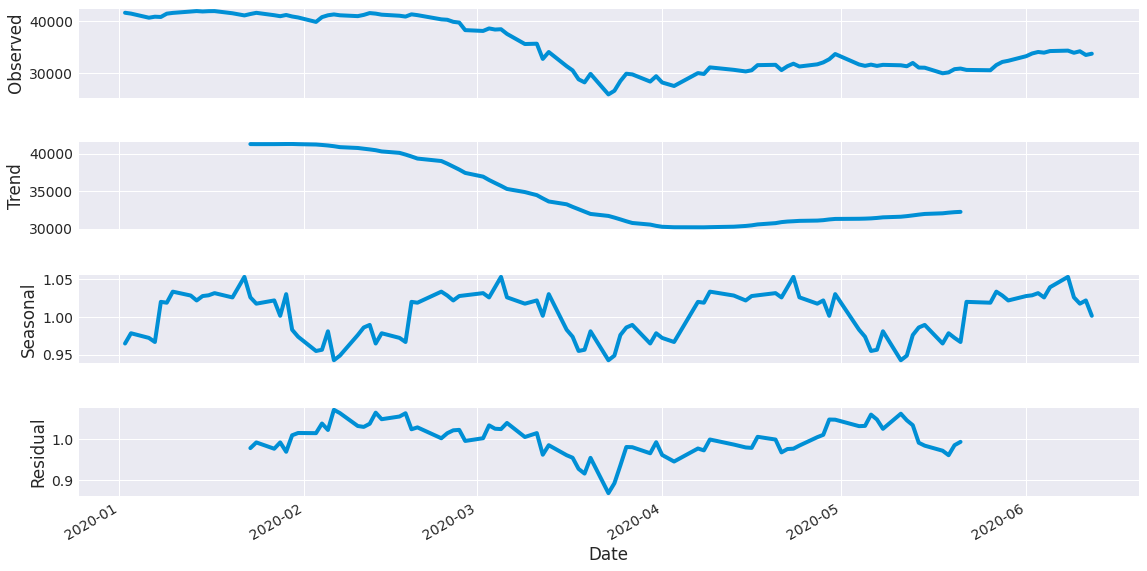

In [ ]:
#Additive Seasonality
add_seasonality = seasonal_decompose(df["Close"], model='additive', freq = 30)
fig = plt.figure()  
fig = mult_seasonality.plot()  
fig.set_size_inches(16, 9)

## Moving Average

No handles with labels found to put in legend.


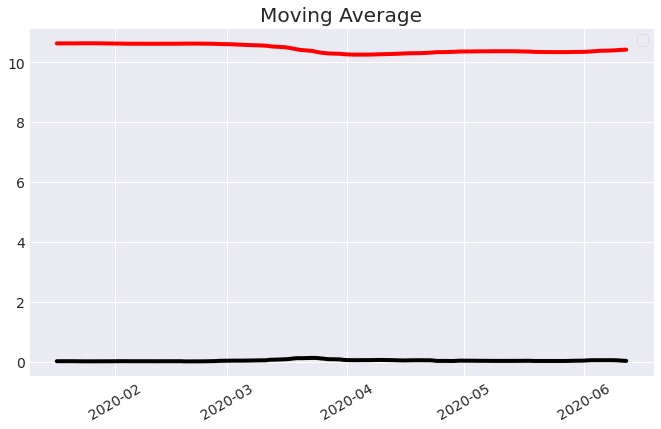

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_close=df["Close"]
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.xticks(rotation=30)
plt.show()

# Train Test split of data

In [ ]:
size = int(len(df)*0.8)
df_train1, df_test1 = df.iloc[:size], df.iloc[size:]
df_train=df_train1.Close
df_train=df_train.to_frame()
df_test=df_test1.Close
df_test=df_test.to_frame()

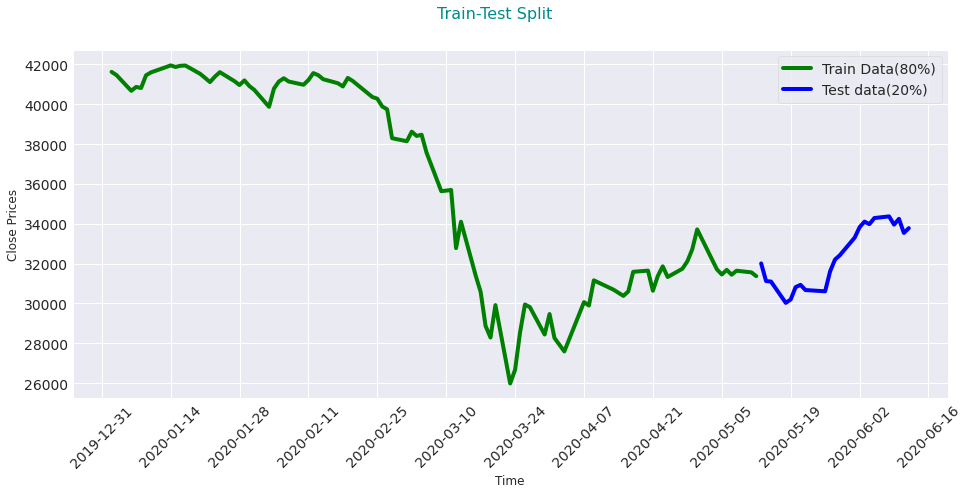

In [ ]:
rcParams['figure.figsize'] = 14,6
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("Train-Test Split", fontsize=16, color='darkcyan')
plt.xticks(rotation=45)
ax = sns.lineplot(data=df_train["Close"], color="green", label='Train Data(80%)')
ax = sns.lineplot(data=df_test["Close"], color="blue", label='Test data(20%)')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))


# ARIMA

In [ ]:
# Determine the orders of ARIMA Model

model_autoARIMA = auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=5,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Fit ARIMA: order=(0, 0, 0); AIC=1739.916, BIC=1744.848, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0); AIC=1450.860, BIC=1458.258, Fit time=0.104 seconds
Fit ARIMA: order=(0, 0, 1); AIC=1642.695, BIC=1650.093, Fit time=0.086 seconds
Fit ARIMA: order=(2, 0, 0); AIC=1450.665, BIC=1460.529, Fit time=0.162 seconds
Fit ARIMA: order=(2, 0, 1); AIC=1452.514, BIC=1464.844, Fit time=0.213 seconds
Fit ARIMA: order=(3, 0, 1); AIC=1452.054, BIC=1466.850, Fit time=0.171 seconds
Fit ARIMA: order=(3, 0, 0); AIC=1452.324, BIC=1464.654, Fit time=0.215 seconds
Total fit time: 0.964 seconds
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   87
Model:                     ARMA(2, 0)   Log Likelihood                -721.333
Method:                       css-mle   S.D. of innovations            946.313
Date:                Sun, 14 Jun 2020   AIC                           1450.665
Time:                 

In [ ]:
# Custom settings for AutoARIMA
model_ar1 = ARIMA(df_train, order = (1,0,0))
results_ar = model_ar1.fit()
print(results_ar.summary())


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                   87
Model:                     ARMA(1, 0)   Log Likelihood                -722.430
Method:                       css-mle   S.D. of innovations            958.591
Date:                Sun, 14 Jun 2020   AIC                           1450.860
Time:                        18:35:17   BIC                           1458.258
Sample:                             0   HQIC                          1453.839
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.629e+04   3916.276      9.267      0.000    2.86e+04     4.4e+04
ar.L1.Close     0.9827      0.015     63.446      0.000       0.952       1.013
                                    Roots       

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
# Make predictions
fc_ar= results_ar.forecast(steps=len(df_test))[0]
fc_ar = pd.DataFrame(fc_ar, index=df_test.index, columns=['prediction'])

### Model Performance

In [ ]:
# Model Stats
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(df_test,fc_ar)
print("MSE for ARIMA = {}".format(MSE))
mae = mean_absolute_error(df_test, fc_ar)
print('MAE: '+str(mae))
rms_arima = sqrt(mean_squared_error(df_test, fc_ar))
print("RMSE for ARIMA = {}".format(rms_arima))

MSE for ARIMA = 1362813.2175615004
MAE: 1050.6399159908563
RMSE for ARIMA = 1167.3959129453472


# Auto ARIMA

In [ ]:
model_ar = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
model_ar.fit(df_train)
print(model_ar.summary())


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1435.256, BIC=1449.982, Fit time=0.229 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1428.343, BIC=1433.252, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1429.856, BIC=1437.219, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1429.850, BIC=1437.213, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1431.833, BIC=1441.650, Fit time=0.093 seconds
Total fit time: 0.395 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   87
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -712.171
Date:                Sun, 14 Jun 2020   AIC                           1428.343
Time:                        18:35:17   BIC                           1433.252
Sample:                             0   

In [ ]:
# make predictions
fc_autoar = model_ar.predict(n_periods=len(df_test))
fc_autoar = pd.DataFrame(fc_autoar ,index = df_test.index, columns=['prediction'])

### Model Performance

In [ ]:
#Model stats
from sklearn.metrics import mean_squared_error
MSE1=mean_squared_error(df_test,fc_autoar)
print("MSE for Auto ARIMA = {}".format(MSE1))
mae = mean_absolute_error(df_test, fc_autoar)
print('MAE: '+str(mae))
rms_autoarima = sqrt(mean_squared_error(df_test, fc_autoar))
print("RMSE for Auto ARIMA = {}".format(rms_autoarima))

MSE for Auto ARIMA = 10642112.916354604
MAE: 2546.8463727737944
RMSE for Auto ARIMA = 3262.2251480170103


# Forecast Visualization

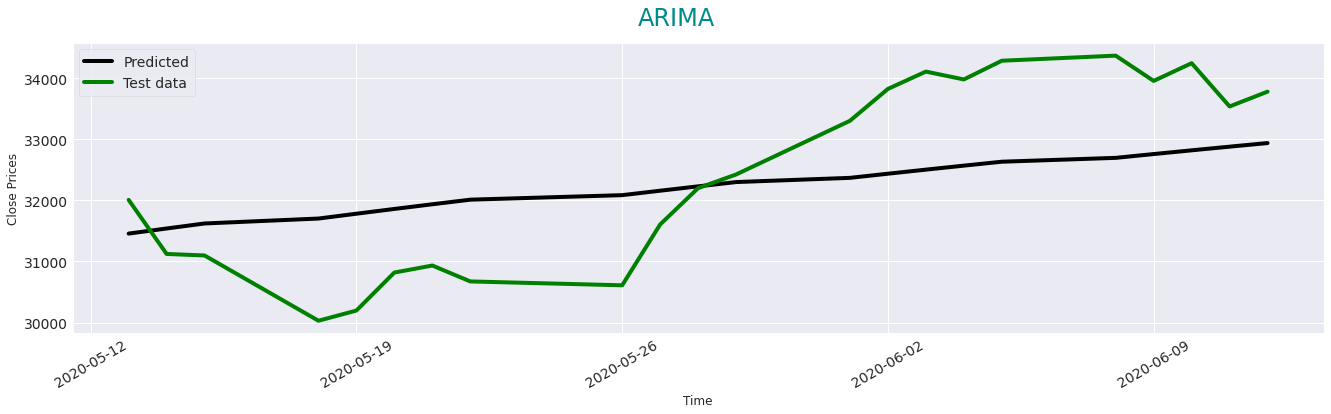

In [ ]:
# ARIMA
rcParams['figure.figsize'] = 20,5
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("ARIMA", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=fc_ar["prediction"], color="black", label='Predicted')
ax = sns.lineplot(data=df_test["Close"], color="green", label='Test data')
#ax = sns.lineplot(data=df_train["Close"], color="teal", label='Train data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

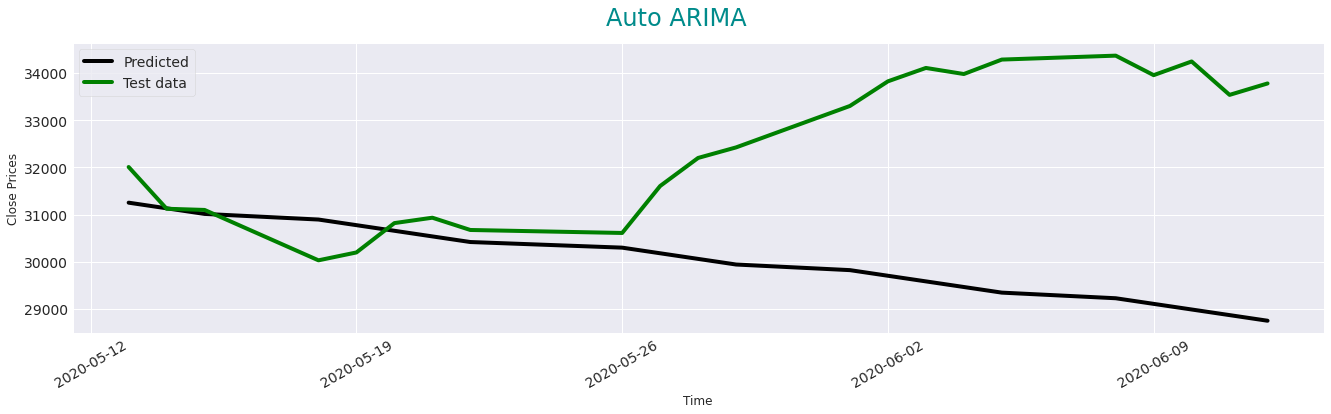

In [ ]:
# AUTO ARIMA
rcParams['figure.figsize'] = 20,5
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("Auto ARIMA", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=fc_autoar["prediction"], color="black", label='Predicted')
ax = sns.lineplot(data=df_test["Close"], color="green", label='Test data')
#ax = sns.lineplot(data=df_train["Close"], color="teal", label='Train data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

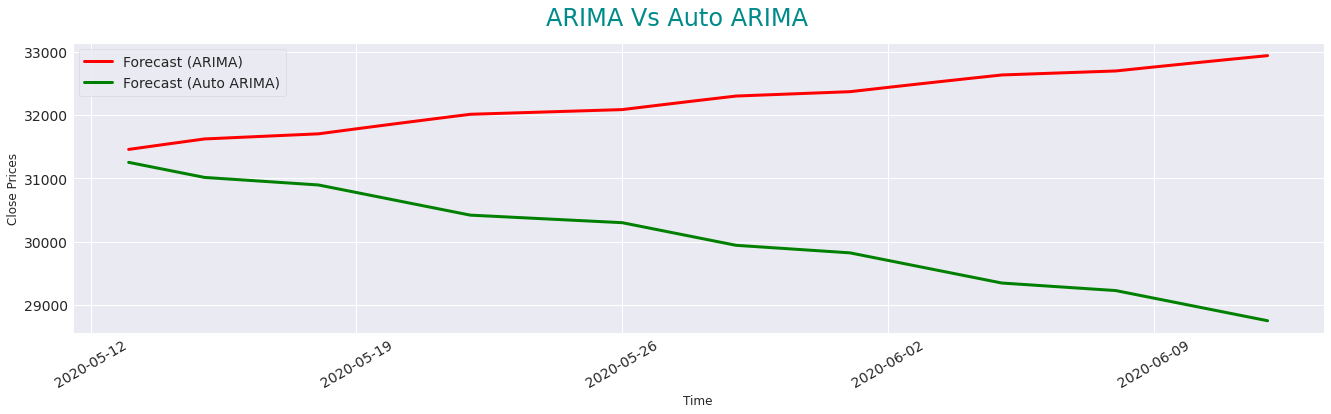

In [ ]:
# ARIMA vs AutoARIMA
rcParams['figure.figsize'] = 20,5
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("ARIMA Vs Auto ARIMA", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=fc_ar["prediction"], color="red", label='Forecast (ARIMA)',linewidth=3.0)
ax = sns.lineplot(data=fc_autoar["prediction"], color="green", label='Forecast (Auto ARIMA)', linewidth=3.0)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### With confidence interval

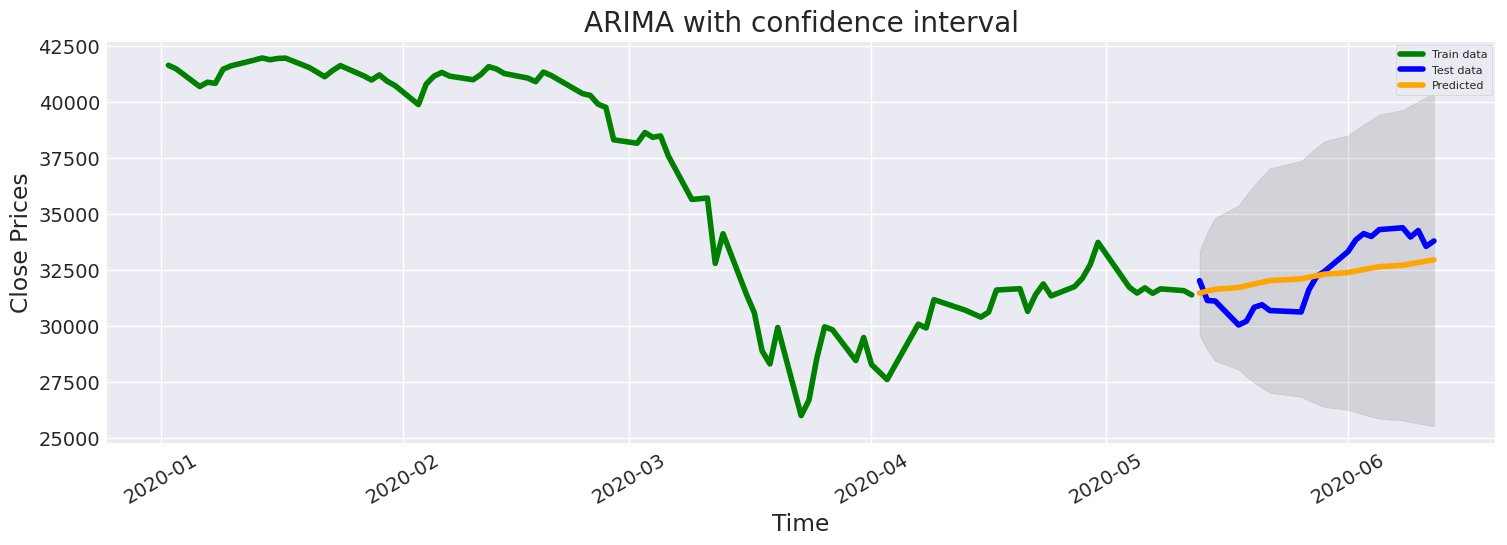

In [ ]:

# Forecast ARIMA
fc, se, conf = results_ar.forecast(len(df_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_train, label='Train data', color= 'green')
plt.plot(df_test, color = 'blue', label='Test data')
plt.plot(fc_ar, color = 'orange',label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('ARIMA with confidence interval')
plt.xlabel('Time')
plt.ylabel('Close Prices')
plt.legend(loc='upper right', fontsize=8)
plt.xticks(rotation=30)
plt.show()

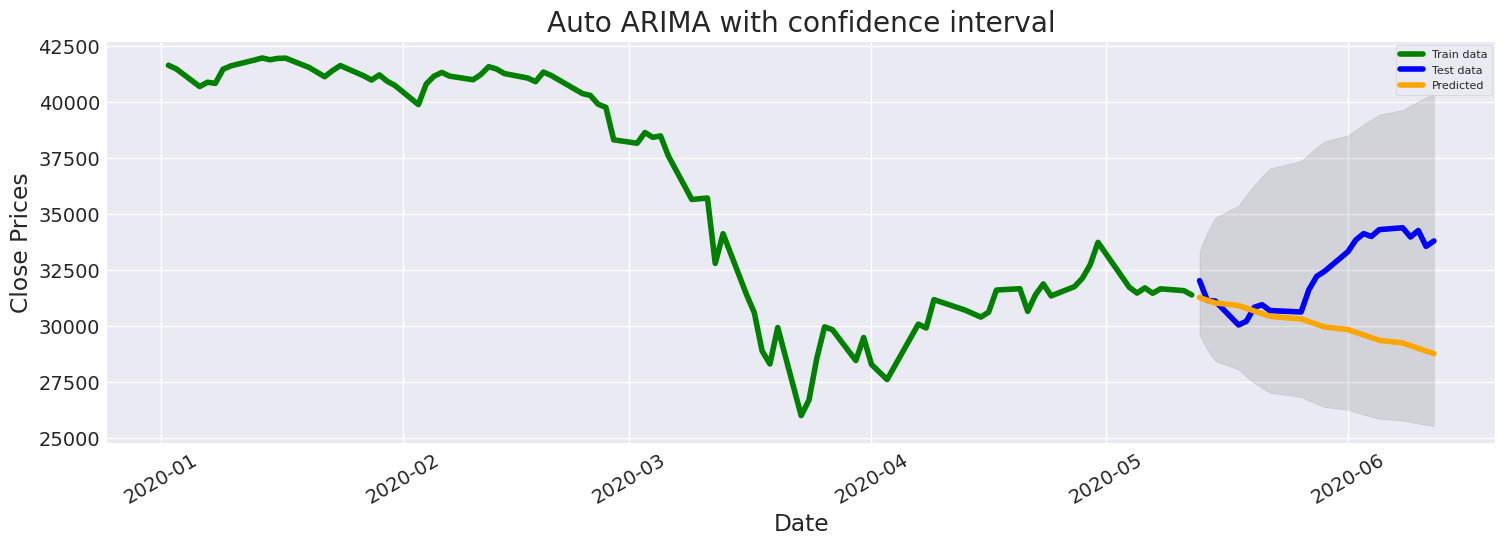

In [ ]:

# Forecast Auto ARIMA
fc, se, conf = results_ar.forecast(len(df_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_train, label='Train data', color= 'green')
plt.plot(df_test, color = 'blue', label='Test data')
plt.plot(fc_autoar, color = 'orange',label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Auto ARIMA with confidence interval')
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.legend(loc='upper right', fontsize=8)
plt.xticks(rotation=30)
plt.show()

# LSTM


In [ ]:
training_set=df_train[:]
testing_set=df_test[:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(1, len(training_set)):
    X_train.append(training_set_scaled[i-1:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
len(X_train)

86

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.python.framework import ops
ops.reset_default_graph()

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4973
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4835
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4694
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4547
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4371
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4183
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 0.3987
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.3733
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.3451
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.3119
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 0.2778
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 0.2341
Epoch 13/100
3/3 [==============================] - 0s 6ms/st

In [ ]:
dataset_total = pd.concat((training_set['Close'], testing_set['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testing_set) :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(1, len(testing_set)):
    X_test.append(inputs[i-1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
testing_set1=testing_set[1:len(testing_set)]
fc_LSTM = pd.DataFrame(predicted_stock_price ,index = testing_set1.index, columns=['prediction'])

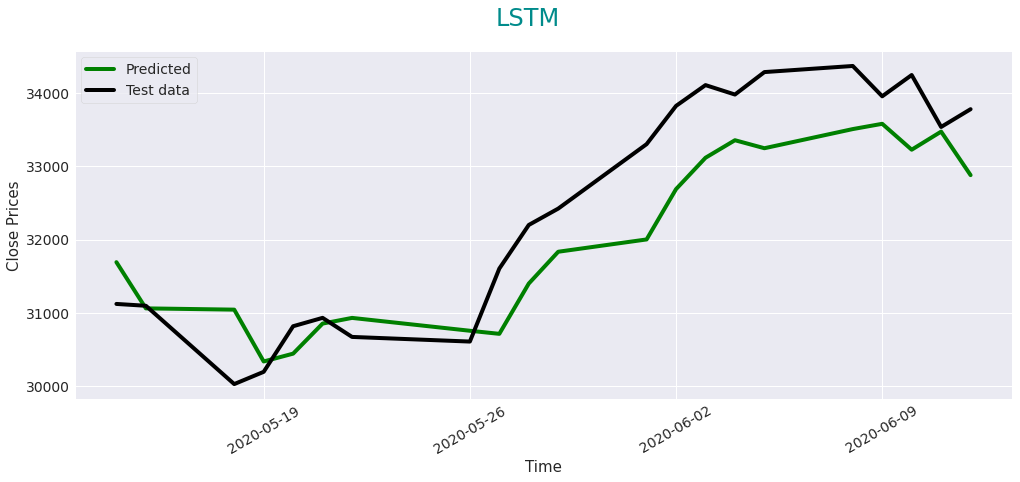

In [ ]:
# LSTM
rcParams['figure.figsize'] = 15,6
plt.xlabel("Time",fontsize=15)
plt.ylabel("Close Prices", fontsize=15)
plt.suptitle("LSTM", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=fc_LSTM["prediction"], color="green", label='Predicted')
ax = sns.lineplot(data=testing_set1["Close"], color="black", label='Test data')
#ax = sns.lineplot(data=training_set["Close"], color="teal", label='Train data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

In [ ]:

rms_LSTM = (np.sqrt(mean_squared_error(testing_set1, predicted_stock_price)))
test_set_r2 = r2_score(testing_set1, predicted_stock_price)
print("RMSE {}".format(rms_LSTM))
print("R2 Score {}".format(test_set_r2))

RMSE 742.0431782589123
R2 Score 0.7689645201350556


# Prophet

### Additive Seasonality

In [ ]:
train=df_train[:]
test=df_test[:]
train["ds"] = df_train.index
train[ "y"] = df_train.Close

In [ ]:
# fit the model
model = Prophet(seasonality_mode="additive", daily_seasonality=True)
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Predict
future = model.make_future_dataframe(periods=len(test),freq='D')
forecast = model.predict(future)

In [ ]:
# get the forecast values
forecast_valid = forecast["yhat"][len(train):]

In [ ]:
# insert prediction values into validation set
test.insert(loc=1, column="prediction", value=forecast_valid.values)

In [ ]:
# calculate rmse
rms_prophet_as = sqrt(mean_squared_error(test["Close"], forecast_valid))
print("RMSE for Prophet = {}".format(rms_prophet_as))

RMSE for Prophet = 3055.249674144982


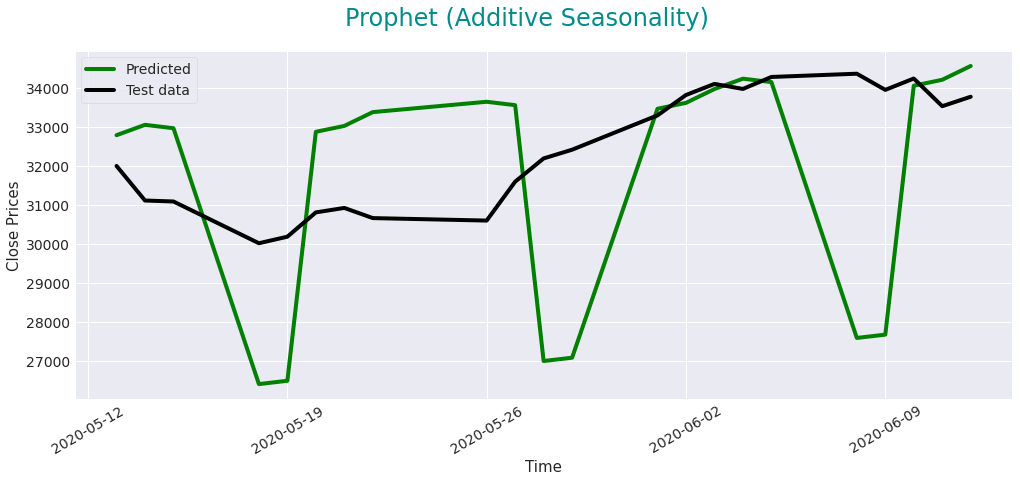

In [ ]:
# Prophet Additive
rcParams['figure.figsize'] = 15,6
plt.xlabel("Time",fontsize=15)
plt.ylabel("Close Prices", fontsize=15)
plt.suptitle("Prophet (Additive Seasonality)", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=test["prediction"], color="green", label='Predicted')
ax = sns.lineplot(data=testing_set["Close"], color="black", label='Test data')
#ax = sns.lineplot(data=train["y"], color="teal", label='Train data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))



Text(0.5, 0.99, 'Prophet (Additive Seasonality)')

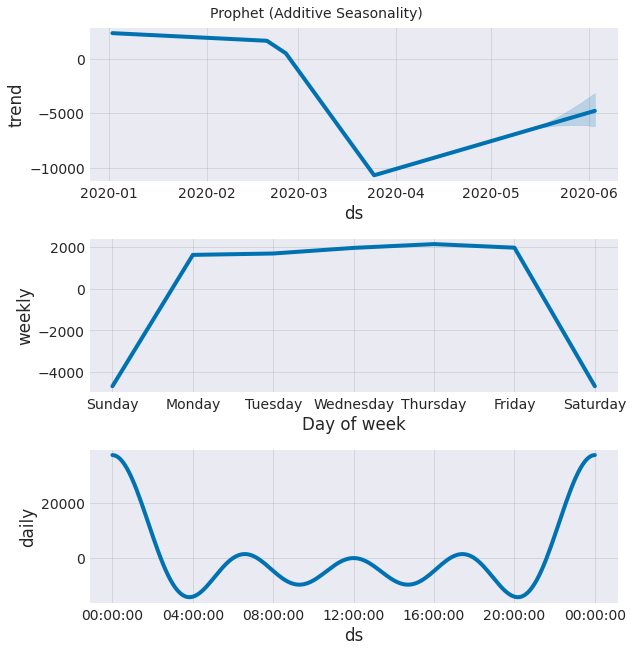

In [ ]:
# plot the components
fig_components = model.plot_components(forecast)
fig_components.text(0.5, 0.99, "Prophet (Additive Seasonality)", ha="center", fontsize=14)


### Multiplicative Seasonality

In [ ]:
train1=df_train[:]
test1=df_test[:]
train1["ds"] = df_train.index
train1[ "y"] = df_train.Close

In [ ]:
# fit the model
model1 = Prophet(seasonality_mode="multiplicative", daily_seasonality=True)
model1.fit(train1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# make predictions
future1 = model1.make_future_dataframe(periods=len(test1), freq="D")
forecast1 = model1.predict(future1)

In [ ]:
# get the forecast values
forecast_valid1 = forecast1["yhat"][len(train1):]

In [ ]:
# insert prediction values into validation set
test1.insert(loc=1, column="prediction", value=forecast_valid1.values)

In [ ]:
# calculate rmse
rms_prophet_ms = sqrt(mean_squared_error(test1["Close"], forecast_valid1))
print("RMSE for Prophet = {}".format(rms_prophet_ms))

RMSE for Prophet = 2981.401933966215


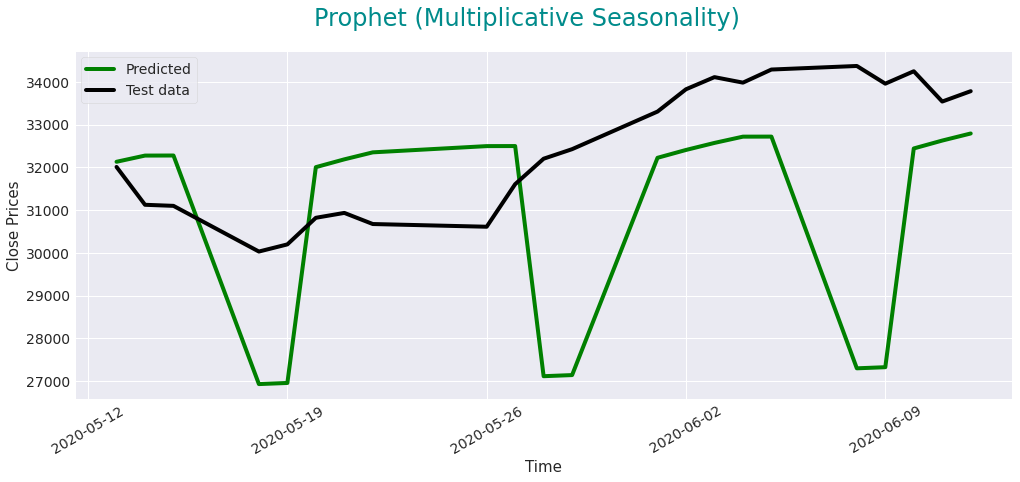

In [ ]:
# Prophet Multiplicative
rcParams['figure.figsize'] = 15,6
plt.xlabel("Time",fontsize=15)
plt.ylabel("Close Prices", fontsize=15)
plt.suptitle("Prophet (Multiplicative Seasonality)", fontsize=24, color='darkcyan')
plt.xticks(rotation=30)
ax = sns.lineplot(data=test1["prediction"], color="green", label='Predicted')
ax = sns.lineplot(data=test1["Close"], color="black", label='Test data')
#ax = sns.lineplot(data=train["y"], color="teal", label='Train data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

Text(0.5, 0.99, 'Prophet (Multiplicative Seasonality)')

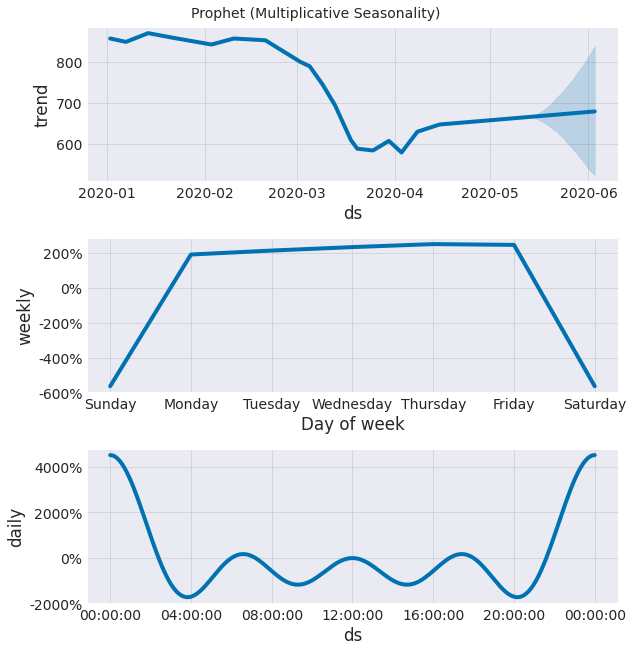

In [ ]:
# plot the components
fig_components = model1.plot_components(forecast1)
fig_components.text(0.5, 0.99, "Prophet (Multiplicative Seasonality)", ha="center", fontsize=14)


# RMSE Comparison

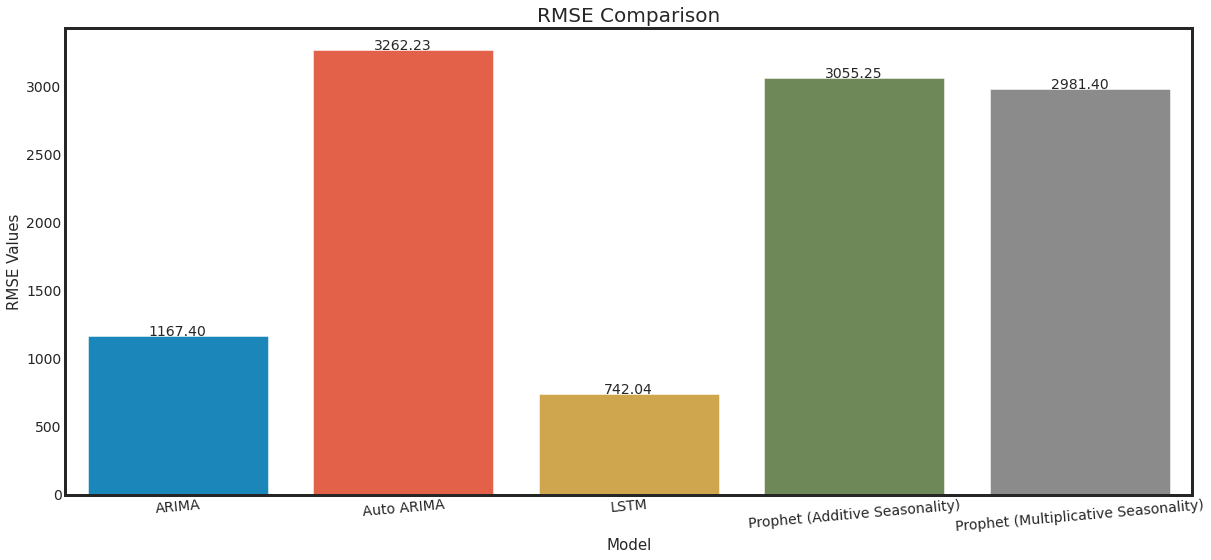

In [ ]:
# combine all models' results into one dataframe
data = {"Model": ["ARIMA", "Auto ARIMA", "LSTM", "Prophet (Additive Seasonality)", "Prophet (Multiplicative Seasonality)"], 
        "RMSE": [rms_arima, rms_autoarima, rms_LSTM, rms_prophet_as, rms_prophet_ms]}

results = pd.DataFrame(data=data)
sns.set_style('white')
ax = sns.barplot(x="Model", y="RMSE", data=results)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+1, "{:1.2f}".format(height), ha="center", fontsize=14) 
plt.title('RMSE Comparison', size=20)
plt.xlabel('Model', size=15)
plt.ylabel('RMSE Values', size=15)
plt.xticks(rotation=5)
plt.show(fig)




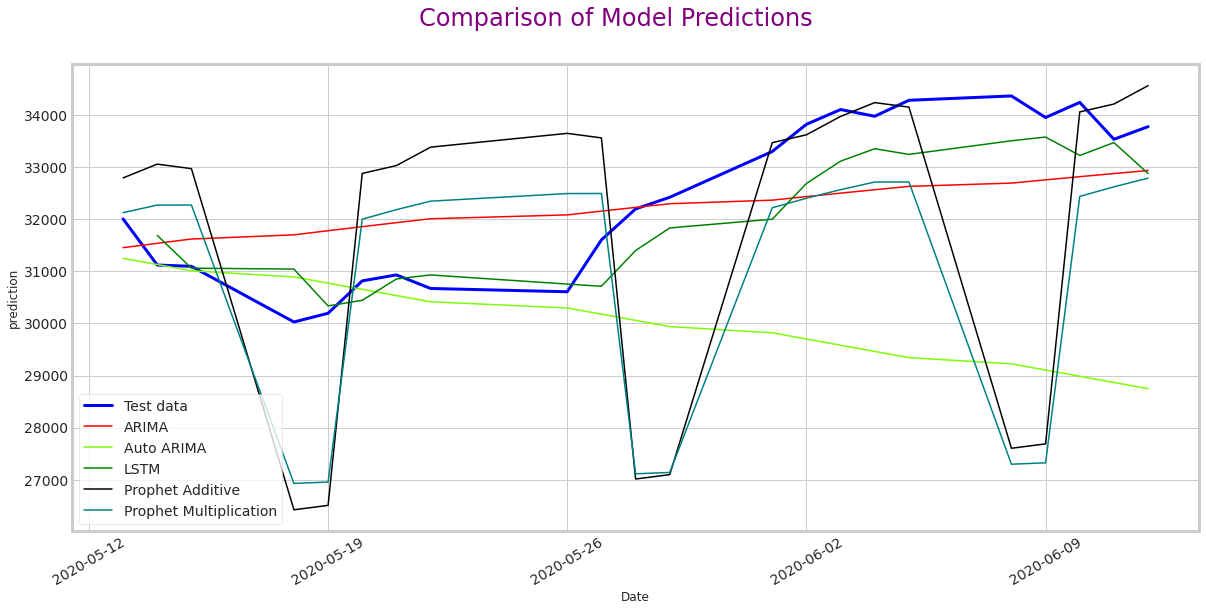

In [ ]:
# Prediction Comparison
rcParams['figure.figsize'] = 18,8
plt.xlabel("Time",fontsize=12)
plt.ylabel("Close Prices", fontsize=12)
plt.suptitle("Comparison of Model Predictions", size = 24, color="Purple")
plt.xticks(rotation=30)
ax = sns.lineplot(data=df_test["Close"], color="blue", label='Test data', linewidth=3.0)
ax = sns.lineplot(data=fc_ar["prediction"], color="red", label='ARIMA', linewidth=1.5)
ax = sns.lineplot(data=fc_autoar["prediction"], color="lawngreen", label='Auto ARIMA', linewidth=1.5)
ax = sns.lineplot(data=fc_LSTM["prediction"], color="green", label='LSTM',  linewidth=1.5)
ax = sns.lineplot(test.index, test["prediction"], label="Prophet Additive", color= "Black",  linewidth=1.5)
ax = sns.lineplot(test1.index, test1["prediction"], label="Prophet Multiplication", color= "teal",  linewidth=1.5)
#ax = sns.lineplot(data=df_train["Close"], color="dodgerblue", label='Train Data')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

In [ ]:
!jupyter nbconvert --to html ARIMA_NIFTY20.ipynb

[NbConvertApp] WARNING | pattern u'ARIMA_NIFTY20.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--inplace
    Run